In [22]:
# all required libraries below
%pip install numpy --quiet
%pip install tonic --quiet
%pip install matplotlib --quiet
%pip install snntorch --quiet
%pip install torch --quiet
%pip install Lempel-Ziv-Complexity --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [24]:
# All imports go here
import numpy as np
import numpy.lib.recfunctions as rf
import tonic
import matplotlib.pyplot as plt
from IPython.display import HTML
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from lempel_ziv_complexity import lempel_ziv_complexity

In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [8]:
# load in the datasets. This dataset is huge (~17gb), so no need to do this more than once. 
# If you are opening this on a google colab, there should be a data pipeline between the colab and a google drive location with the data, so no need to install data locally. 
# tonic.datasets.DVSGesture(save_to="/home/gauravgupta/CMPM118/data", train=True)
# tonic.datasets.DVSGesture(save_to="/home/gauravgupta/CMPM118/data", train=False)


In [ ]:
# each sequence of gestures for each subject is divided into 11 .npy files, which are named according to the target labels. 
# file_name = '/kaggle/input/create-dvs128gesture-tonic-dataset/DVSGesture/ibmGestureTest/user26_led/9.npy'
file_name = '/home/gauravgupta/CMPM118/data/DVSGesture/ibmGestureTest/user26_led/9.npy'

# each file contains a list of events (x-pos, y-pos, polarity, timestamp).
arr = np.load(file_name)
arr[:, 3] *= 1000  # convert from ms to us
dtype = np.dtype([("x", np.int16), ("y", np.int16), ("p", bool), ("t", np.int64)])
arr = rf.unstructured_to_structured(arr, dtype)

print("A single event:", arr[0], "as (x-pos, y-pos, polarity, timestamp).")

# np.savetxt("./DVSGesture/ibmGestureTest/user26_led/9.csv", arr, delimiter=",") # save as csv

A single event: (55, 103, False, 13) as (x-pos, y-pos, polarity, timestamp).


In [42]:
import tonic
import matplotlib.pyplot as plt
from IPython.display import HTML

def to_frames(events):
     # creates dense frames from events by binning them in different ways
    frame_transform = tonic.transforms.ToFrame(
        sensor_size=tonic.datasets.DVSGesture.sensor_size, 
        #time_window=10000)
        n_time_bins=100)
        #event_count=1000)
    return frame_transform(events)

In [ ]:
def calculateLZC(events):
    spike_seq = (events['p'] > 0).astype(int).flatten()  # 1 if spike, 0 if inactive
    spike_seq_string = ''.join(map(str, spike_seq.tolist()))
    lz_score = lempel_ziv_complexity(spike_seq_string)
    print(f"LZ complexity: ", lz_score)

In [27]:
# Calculate lempel ziv complexity for a single piece of data
# 
#  Load in the data. When we do train[1], we are getting one "video" of data. 
dataset_path = '/home/gauravgupta/CMPM118/data'
train = tonic.datasets.DVSGesture(save_to=dataset_path, train=True)
test = tonic.datasets.DVSGesture(save_to=dataset_path, train=False)
events, label = train[8]

calculateLZC(events)


# Flatten temporal frames into binary spike stream


LZ complexity:  7435


In [ ]:
dataset_path = '/home/gauravgupta/CMPM118/data'
train = tonic.datasets.DVSGesture(save_to=dataset_path, train=True)
test = tonic.datasets.DVSGesture(save_to=dataset_path, train=False)

events, label = train[6]
frames = to_frames(events)

print("Train dataset contains", len(train), "samples.")
print("There are", len(events), "events in the selected sample.")
print("A single event:", events[1], "as (x-pos, y-pos, polarity, timestamp).")
print (frames.shape, label)

ani = tonic.utils.plot_animation(frames) # plot one frame
HTML(ani.to_jshtml()) # animate all frames

lzc = ""
lzc_list = []

binary_frames = (frames > 0).astype(int)
flat_frames = binary_frames.reshape(binary_frames.shape[0], -1)
for frame in flat_frames:
    lzc = "".join(map(str, frame))
    lzc_list.append(lempel_ziv_complexity(lzc))

fig, axes = plt.subplots(1, 1, figsize=(18,4))
axes.plot(lzc_list)
axes.set_title("LZC Over Time")
axes.set_xlabel("Frame")
axes.set_ylabel("LZC")

plt.show()

In [ ]:
w,h=32,32
n_frames=10 
debug = False

transforms = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=10000), # removes outlier events with inactive surrounding pixels for 10ms
    tonic.transforms.Downsample(sensor_size=tonic.datasets.DVSGesture.sensor_size, target_size=(w,h)), # downsampling image
    tonic.transforms.ToFrame(sensor_size=(w,h,2), n_time_bins=n_frames), # n_frames frames per trail
])

train2 = tonic.datasets.DVSGesture(save_to=dataset_path, transform=transforms, train=True)
test2 = tonic.datasets.DVSGesture(save_to=dataset_path, transform=transforms, train=False)

cache_root = f"/home/gauravgupta/CMPM118/data/dvsgesture/{w}x{h}_T{n_frames}"
cached_train = tonic.DiskCachedDataset(train2, cache_path=f"{cache_root}/train")
cached_test  = tonic.DiskCachedDataset(test2,  cache_path=f"{cache_root}/test")

frames, label = cached_train[1]
ani = tonic.utils.plot_animation(frames)
print(frames.shape, label)
HTML(ani.to_jshtml())

lzc = ""
lzc_list = []

binary_frames = (frames > 0).astype(int)
flat_frames = binary_frames.reshape(binary_frames.shape[0], -1)
for frame in flat_frames:
    lzc = "".join(map(str, frame))
    lzc_list.append(lempel_ziv_complexity(lzc))

fig, axes = plt.subplots(1, 1, figsize=(18,4))
axes.plot(lzc_list)
axes.set_title("LZC Over Time")
axes.set_xlabel("Frame")
axes.set_ylabel("LZC")

plt.show()

In [45]:
# This is used to figure out how many fully connected neurons need to be present in the last layer. This number depends on the w and h values. 

test_input = torch.zeros((1, 2, w, h))  # 2 polarity channels
x = nn.Conv2d(2, 12, 5)(test_input)
x = nn.MaxPool2d(2)(x)
x = nn.Conv2d(12, 32, 5)(x)
x = nn.MaxPool2d(2)(x)
print("Output shape before flatten:", x.shape)
print("Flattened size:", x.numel())
flattenedSize = x.numel()


Output shape before flatten: torch.Size([1, 32, 5, 5])
Flattened size: 800


In [ ]:
grad = snn.surrogate.fast_sigmoid(slope=25) # surrogate.atan()
beta = 0.5

# 12C5-MP2-32C5-MP2-800FC11 https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_7.html
net = nn.Sequential(
    nn.Conv2d(2, 12, 5), # in_channels, out_channels, kernel_size
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True),
    nn.Conv2d(12, 32, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True),
    nn.Flatten(),
    nn.Linear(flattenedSize, 11),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True, output=True)
).to(device)

def forward_pass(net, data):
    spk_rec = []
    snn.utils.reset(net)  # resets hidden states for all LIF neurons in net
    for step in range(data.size(0)): # data.size(0) = number of time steps
        spk_out, mem_out = net(data[step].to("cuda"))
        spk_rec.append(spk_out)
    return torch.stack(spk_rec)

optimizer = torch.optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

loss_hist = []
acc_hist = []
test_acc_hist = []

In [47]:
def validate_model():
    correct, total = 0, 0  
    for batch, (data, targets) in enumerate(iter(test_loader)): 
        data, targets = data.to(device), targets.to(device) # [n_frames, batch, polarity, x-pos, y-pos] [batch] 
        spk_rec = forward_pass(net, data)         
        correct += SF.accuracy_rate(spk_rec, targets) * data.shape[0]
        total += data.shape[0]
    return correct/total

In [50]:
# This cell is just for debugging. Not important
print(n_frames)
print(h, w)

10
32 32


In [ ]:
num_epochs = 100
cnt = 0
active_cores = 4

train_loader = torch.utils.data.DataLoader(cached_train, batch_size=64, shuffle=True, num_workers = active_cores, drop_last=True, 
                                           collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = torch.utils.data.DataLoader(cached_test, batch_size=32, shuffle=True, num_workers = active_cores, drop_last=True, 
                                          collate_fn=tonic.collation.PadTensors(batch_first=False))

for epoch in range(num_epochs):
    for batch, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        # propagating one batch through the network and evaluating loss
        spk_rec = forward_pass(net, data)
        loss = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss.item())

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        if cnt % 15 == 0:
            print(f"Epoch {epoch}, Iteration {batch} \nTrain Loss: {loss.item():.2f}")
            print(f"Train Accuracy: {acc * 100:.2f}%")
            test_acc = validate_model()            
            test_acc_hist.append(test_acc)
            print(f"Test Accuracy: {test_acc * 100:.2f}%\n")

        cnt+=1

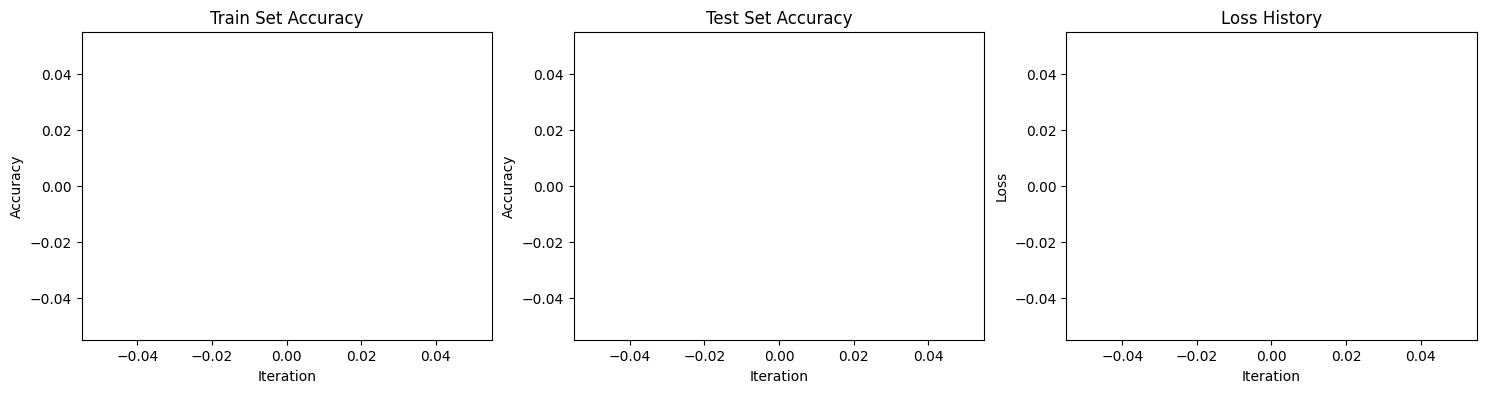

In [56]:
# this file basically takes the trained model from the call above, the acc_hist, test_acc_hist, and loss_hist, and puts it in a graph. 
# This file also saves BOTH the model and the graph along with the TRIAL NUMBER. This number is automatically updated. 



fig, axes = plt.subplots(1, 3, figsize=(18,4))

# Plot Train Accuracy
axes[0].plot(acc_hist)
axes[0].set_title("Train Set Accuracy")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")

# Plot Test Accuracy
axes[1].plot(test_acc_hist)
axes[1].set_title("Test Set Accuracy")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Accuracy")

# Plot Training Loss
axes[2].plot(loss_hist)
axes[2].set_title("Loss History")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Loss")


# The part below automatically saves the model/accuracy graph in a unique file without you having to do anything

experiment_counter_file_path = "results/large/experiment_counter.txt"
with open(experiment_counter_file_path, "r") as f:
        num_str = f.read().strip()
        num = int(num_str)

num += 1

with open(experiment_counter_file_path, "w") as f:
    f.write(str(num))

model_save_path = f"results/large/models/Large_Take{num}.pth"
graph_save_path = f"results/large/graphs/Large_Take{num}.png"

torch.save(net.state_dict(), model_save_path) 
plt.savefig(graph_save_path)
plt.show()


